In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import matplotlib as mpl
sys.path.append('../python/')
os.environ['MPLCONFIGDIR'] = '../mplstyles'


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])

import numpy as np
#set up a plot 
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

# ER/NR Band Calculation

In a previous notebook `QEr_2D_joint.ipynb` we calculated the correct two-dimensional probability distribution for energy recoils of arbitrary average ionization yield, given the resolutions ($\sigma_H$,$\sigma_I$, and $\sigma_N$) as functions of the true recoil energy. The variance on the number of e/h pairs created, $\sigma_N$ included the effective Fano factor, $F$. 

This was all done starting from the fundamental variables $\delta H$, $\delta I$, and N (see `QEr_2D_joint.ipynb` for all variable definitions). The final result was the probability distribution in the Q,$\tilde{E}_r$ plane of measured yield and recoil energy, given a true recoil distribution $P(E_r)$. $P(E_r)$ was taken to be:

\begin{equation}
P(E_r) = \frac{1}{\alpha}e^{-\alpha E_r},
\end{equation}

where $\alpha$ is the decay constant and we take to be equal to about 1/100 keV$^{-1}$ for nuclear recoils.

In this note we will use this model to construct the variance of constant-$\tilde{E}_r$ slices of this distribution. The motivation for this calculation is that these variances are often the ones measured in experiments like Edelweiss [REF] and SuperCDMS. 

## Ionization Yield Distributions at Fixed $\tilde{E}_r$

First, we want to construct bands for electron recoils with the parameters $F^{\prime}$=0 (Fano factor) and $\alpha^{\prime}$ = 1/100000 keV$^{-1}$ (essentially flat true recoil distribution).

**NOTE: The value of $F^{\prime}$ is choosen as such because the measured resolutions are done with electron recoils and implicitly include the true Fano factor. Although this Fano factor (typically in germanium of order 0.13 with large variability in the measurements [REF]) is included note that it is not included correctly because it is not separated from the variance of $\delta I$. Nevertheless, since the Fano contribution for electron recoils is small compared to the ionization resolutions in most published work, it is safely parameterized inside the $\delta I$ resolution for electron recoils.**

Next we will construct a nuclear recoil band with the parameters $F$=15 (this appears to be a plausible lower limit for measurements above 10 keV, see [REF] Dougherty, and the notebook constructing the Fano factor from that) and $\alpha$=1/100 keV$^{-1}$. 

We are constructing the distribution that results from the following:

\begin{equation}
P(Q,\tilde{E}_r=E) = \int_0^{\infty} dE_r P(Q,\tilde{E}_r=E|E_r)P(E_r)
\end{equation}

In [2]:
#constants
V=4.0 #volts
eps = 3.0/1000 #keV per pair, I usually use 3.3 for the numerator, but Edw. uses 3.

#yield models
a=0.16
b=0.18
Qbar = lambda Er: a*Er**b
Qer = lambda Er: 1

In [3]:
#getting the resolutions
import EdwRes as er

fh1 = er.get_heatRes_func(0.4, 3.5)
heatRes_GGA110 = lambda x: (1/2.355)*fh1(x) #these return FWHM values

fi1 = er.get_ionRes_func(1.1, 1.3, 3.0)
sigI_GGA110 = lambda x:(1/2.355)*fi1(x)

fh2 = er.get_heatRes_func(0.4, 2.7)
heatRes_GGA3 = lambda x:(1/2.355)*fh2(x)

fi2 = er.get_ionRes_func(1.3, 1.5, 3.1)
sigI_GGA3 = lambda x:(1/2.355)*fi2(x)

#new resolution functions 
Ehee = lambda Er: ((1+(V/eps)*Qbar(Er))*Er)/(1+(V/eps))
EIee = lambda Er: Qbar(Er)*Er

heatRes_GGA110_NR = lambda Er: heatRes_GGA110(Ehee(Er))

sigI_GGA110_NR = lambda Er: sigI_GGA110(EIee(Er))

heatRes_GGA3_NR = lambda Er: heatRes_GGA3(Ehee(Er))

sigI_GGA3_NR = lambda Er: sigI_GGA3(EIee(Er))

In [4]:
import prob_dist as pd

#set up ER distribution
Fp = 0.0001
alphap=1/100000
Per = pd.QEr_v2_2D_fast(heatRes_GGA3,sigI_GGA3,V,eps,Fp,Qer)
er_band = pd.expband_2D(Per,alphap,3)

#set up NR distribution
F = 10
alpha=1/100.0
Pnr = pd.QEr_v2_2D_fast(heatRes_GGA3_NR,sigI_GGA3_NR,V,eps,F,Qbar)
nr_band = pd.expband_2D(Pnr,alpha,1.5)

In [5]:
#test the dists at a certain energy
Etest=10

from scipy import integrate
ernorm = integrate.quad(er_band,0,4,args=(Etest,))[0]
nrnorm = integrate.quad(nr_band,0,4,args=(Etest,))[0]
print(ernorm)
print(nrnorm)

X=np.arange(0,1.5,0.01)
er_bandv=np.vectorize(er_band)
nr_bandv=np.vectorize(nr_band)
Etestv = np.ones(np.shape(X))*Etest
print(np.shape(Etestv))
print(np.shape(X))
Yer = (1/ernorm)*er_bandv(X,Etestv)
Ynr = (1/nrnorm)*nr_bandv(X,Etestv)

100049.29364200294
88.56574774394922
(150,)
(150,)


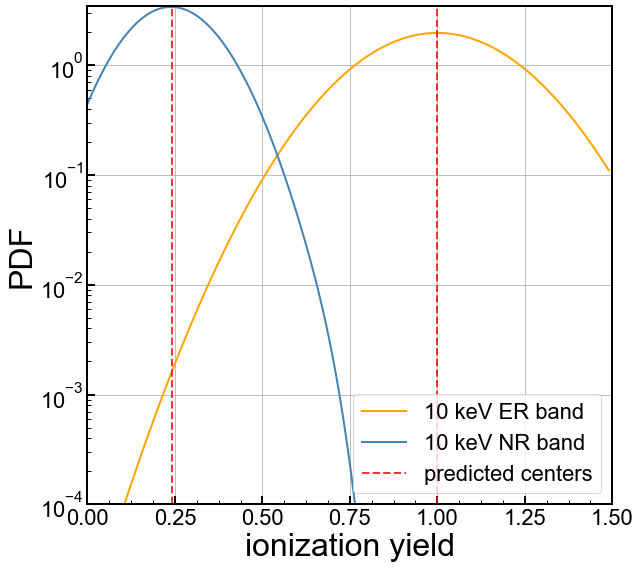

In [6]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



ax1.plot(X,Yer,color='orange',linestyle='-',label='{} keV ER band'.format(Etest))
ax1.plot(X,Ynr,color='steelblue',linestyle='-',label='{} keV NR band'.format(Etest))

ax1.axvline(Qbar(Etest), color='r', linestyle='--', lw=2, alpha=0.8,label='predicted centers')
ax1.axvline(1, color='r', linestyle='--', lw=2, alpha=0.8)

ymin = 1e-4
max1 = np.max(Yer)
max2 = np.max(Ynr)
ymax = 1.01*np.max(np.asarray([max1,max2]))

ax1.set_yscale('linear')
ax1.set_yscale('log')
ax1.set_xlim(0, 1.5) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
#ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

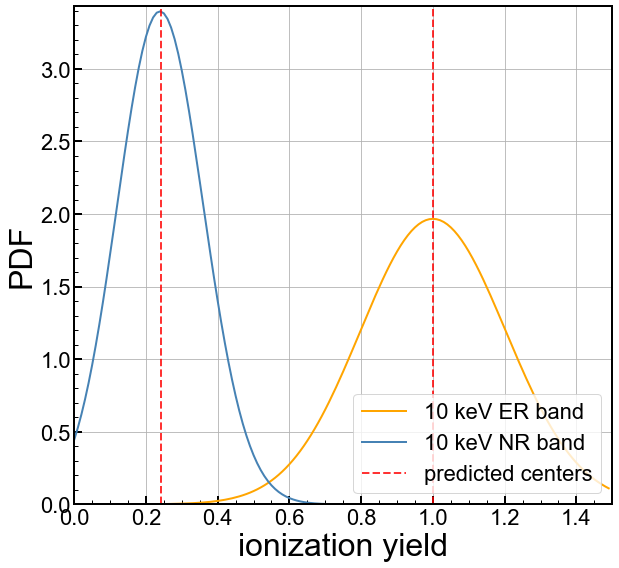

In [7]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



ax1.plot(X,Yer,color='orange',linestyle='-',label='{} keV ER band'.format(Etest))
ax1.plot(X,Ynr,color='steelblue',linestyle='-',label='{} keV NR band'.format(Etest))

ax1.axvline(Qbar(Etest), color='r', linestyle='--', lw=2, alpha=0.8,label='predicted centers')
ax1.axvline(1, color='r', linestyle='--', lw=2, alpha=0.8)

ymin = 1e-4
max1 = np.max(Yer)
max2 = np.max(Ynr)
ymax = 1.01*np.max(np.asarray([max1,max2]))

ax1.set_yscale('linear')
ax1.set_yscale('linear')
ax1.set_xlim(0, 1.5) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'ionization yield',**axis_font)
ax1.set_ylabel('PDF',**axis_font)
ax1.grid(True)
#ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=4,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()